reference: https://www.kaggle.com/danielkorth/ubiquant-fastai-baseline

In [1]:
import os
import gc
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

from fastai.tabular.all import *

In [2]:
set_seed(42)

In [3]:
%%time

# from https://www.kaggle.com/valleyzw/ubiquant-lgbm-baseline
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in tqdm(df.columns):
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


train = reduce_mem_usage(pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet'))

for col in ['time_id', 'investment_id']:
    train[col] = train[col].astype(int)

Memory usage of dataframe is 3642.99 MB


  0%|          | 0/304 [00:00<?, ?it/s]

Memory usage after optimization is: 1915.96 MB
Decreased by 47.4%
CPU times: user 1min 44s, sys: 2min 16s, total: 4min
Wall time: 4min 4s


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: category(1), float16(301), int64(2)
memory usage: 1.9 GB


In [5]:
split = RandomSplitter(valid_pct =0.1)(range_of(train))

feature = [f'f_{i}' for i in range(300)]

In [6]:
to = TabularPandas(train, y_names = 'target',
                   cont_names = feature, splits = split)
lds = to.dataloaders(bs = 4096)

In [7]:
lds.show_batch()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59,f_60,f_61,f_62,f_63,f_64,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79,f_80,f_81,f_82,f_83,f_84,f_85,f_86,f_87,f_88,f_89,f_90,f_91,f_92,f_93,f_94,f_95,f_96,f_97,f_98,f_99,f_100,f_101,f_102,f_103,f_104,f_105,f_106,f_107,f_108,f_109,f_110,f_111,f_112,f_113,f_114,f_115,f_116,f_117,f_118,f_119,f_120,f_121,f_122,f_123,f_124,f_125,f_126,f_127,f_128,f_129,f_130,f_131,f_132,f_133,f_134,f_135,f_136,f_137,f_138,f_139,f_140,f_141,f_142,f_143,f_144,f_145,f_146,f_147,f_148,f_149,f_150,f_151,f_152,f_153,f_154,f_155,f_156,f_157,f_158,f_159,f_160,f_161,f_162,f_163,f_164,f_165,f_166,f_167,f_168,f_169,f_170,f_171,f_172,f_173,f_174,f_175,f_176,f_177,f_178,f_179,f_180,f_181,f_182,f_183,f_184,f_185,f_186,f_187,f_188,f_189,f_190,f_191,f_192,f_193,f_194,f_195,f_196,f_197,f_198,f_199,f_200,f_201,f_202,f_203,f_204,f_205,f_206,f_207,f_208,f_209,f_210,f_211,f_212,f_213,f_214,f_215,f_216,f_217,f_218,f_219,f_220,f_221,f_222,f_223,f_224,f_225,f_226,f_227,f_228,f_229,f_230,f_231,f_232,f_233,f_234,f_235,f_236,f_237,f_238,f_239,f_240,f_241,f_242,f_243,f_244,f_245,f_246,f_247,f_248,f_249,f_250,f_251,f_252,f_253,f_254,f_255,f_256,f_257,f_258,f_259,f_260,f_261,f_262,f_263,f_264,f_265,f_266,f_267,f_268,f_269,f_270,f_271,f_272,f_273,f_274,f_275,f_276,f_277,f_278,f_279,f_280,f_281,f_282,f_283,f_284,f_285,f_286,f_287,f_288,f_289,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
0,0.296875,0.113281,-0.094360,-0.492920,-0.320312,-0.532715,-0.221802,-0.692383,0.123596,-0.708984,0.495117,0.840820,0.718750,-0.118958,-0.291748,-0.499512,-0.771484,0.882812,0.244385,0.097839,-0.463135,-0.859375,0.280273,-0.686523,-0.587402,-0.522461,-1.030273,-0.668457,-0.986816,0.097412,0.818848,-0.294434,-0.006920,0.309326,0.557129,0.882812,-0.571777,-0.047211,-0.429443,-0.325439,0.119934,0.000000,-0.119629,-0.319580,-0.033325,0.230957,1.278320,-0.210205,1.218750,-0.006989,-1.631836,-0.833008,0.395264,1.120117,-0.738770,-0.346436,0.499512,-0.800781,-0.450684,-0.411133,0.771973,-0.272705,-0.186523,-0.206909,0.103455,-0.791992,-0.515625,-0.859863,-0.217285,-0.373291,-0.802246,-0.638184,-0.462158,-0.889648,0.148315,0.363525,0.398193,-0.187378,-0.078674,-0.899902,0.021027,0.997559,-1.057617,-0.142700,0.287598,-0.532715,-0.688965,-0.597656,-0.691406,0.253418,-0.381592,0.388428,0.834473,-0.326172,0.518555,0.409180,-0.067505,-0.470703,-0.099854,-0.445801,0.609375,-0.565430,0.487061,0.039734,-1.239258,-0.333252,-0.530762,-0.869141,0.063232,0.827637,-0.170776,0.356445,-0.912598,-0.777832,0.526367,-0.682617,-0.125488,-0.553223,0.583984,0.575195,0.972656,-0.628906,-0.199707,-0.493896,0.000000,-0.316650,-0.306885,-0.135742,0.146606,0.117676,0.323486,-0.874512,-1.159180,0.255127,-0.288574,-0.545410,-0.627441,-0.070435,0.519531,0.079285,-0.745605,0.308838,0.289551,0.711914,0.274414,0.084473,-0.314209,0.288330,-0.222656,-0.597168,0.510254,-0.380371,0.706543,0.069946,-0.825684,-0.670410,-0.291504,-0.151489,-0.302002,-1.109375,-0.360840,-0.673340,1.043945,-0.934082,-0.149414,-0.198608,0.257324,-0.683105,-0.686523,-0.024979,1.000000,0.600586,-0.500000,-0.518555,-0.358887,-1.000000,-0.753906,-0.091736,0.536621,0.338623,0.470947,-0.540039,1.000000,0.045013,-1.428711,-1.266602,-0.208862,-0.867676,-0.335693,0.000946,-0.241089,-0.695312,0.510254,-0.621582,0.378906,-0.243408,-0.285889,-0.625000,0.563965,-0.073120,1.000000,-0.080200,0.357178,-0.552734,-0.626465,-0.009773,-0.209473,-0.255127,0.193848,-0.411865,0.089478,-0.573730,0.237305,-0.415039,-0.832520,-0.411377,-0.774414,-0.558105,-0.676758,0.740234,-0.862793,0.337158,0.405029,0.418213,0.004391,0.307373,0.266602,-0.022568,-0.352783,-0.836914,-0.570801,-0.257080,0.683594,-0.466309,-0.979492,-0.379395,-0.497559,-0.346680,0.265625

# model

SuggestedLRs(valley=0.0008317637839354575)

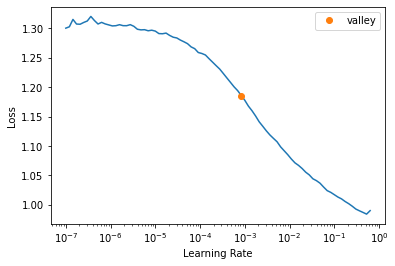

In [8]:
learn = tabular_learner(lds, layers = [300, 100, 30])
learn.lr_find()

In [9]:
learn.fit_one_cycle(5, cbs = [SaveModelCallback(monitor = 'valid_loss', comp = np.less)])

epoch,train_loss,valid_loss,time
0,0.828580,0.828940,01:17
1,0.826274,0.824305,01:17
2,0.823797,0.822009,01:21
3,0.813573,0.819067,01:22
4,0.805229,0.819825,01:18


Better model found at epoch 0 with valid_loss value: 0.8289395570755005.
Better model found at epoch 1 with valid_loss value: 0.8243046998977661.
Better model found at epoch 2 with valid_loss value: 0.8220092058181763.
Better model found at epoch 3 with valid_loss value: 0.8190672397613525.


In [10]:
import ubiquant
env = ubiquant.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission
for (test_df, sample_prediction_df) in iter_test:
    dl = learn.dls.test_dl(test_df)
    y, _ = learn.get_preds(dl=dl)
    sample_prediction_df['target'] = y  # make your predictions here
    env.predict(sample_prediction_df)   # register your predictions

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
